# Exam Introduction

Scale-space blob detection is a technique used to detect blobs in an image by scanning through scale space.

This is important because objects have different physical size (flower example), and the distance to the camera may be unknown. Important for feature based analysis because we may not know at which scale features are in image!

Scale space is a space represented by a one-parameter family of smoothed image (using a Gaussian or derivate of a Gaussian), where the scale $t$ is the scale parameter. Allows us to represent an image at multiple scales. The intepretation here is that at scale $t$, any image structures of spatial size smaller than $\sqrt(t)$ will have been smoothed away. We define scale space at $t$ as:

$$
L(x,y,t) = g_t(x,y)*I
$$

Depending on the feature we want to extract, we convolve with different types of Gaussians. To detect blobs we look for spatial maxima and minima of the scale-space Laplacian:  

$$
\nabla^2 L = L_{xx} + L_{yy}
$$

## Example with known r

* Perform $L_{xx}$ and $L_{yy}$ using $t=25^2/2$ (radius of circles are r=25). 
* Find peak local mins and max. 
* Plot local mins and max.
* Plot r = 25.

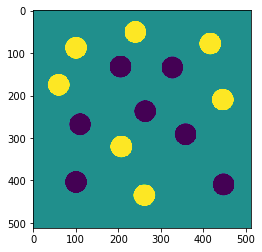

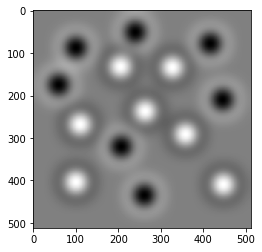

Min:  -0.31814464487021177
Max:  0.281373091264522


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


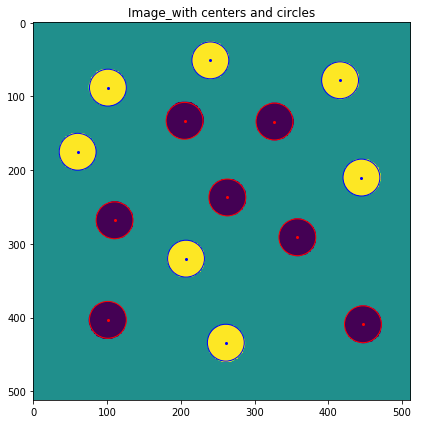

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import math
from skimage import feature

def gaussian(t=3, s=3):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = 1.0/np.sqrt(t*2.0*np.pi)*np.exp(-(x**2.0)/(2.0*t))
    return np.array([filt])

def fst_deriv_gaussian(t=3, s=3):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = (-x/t)*gaussian(t, s=s)
    return np.array([filt])

def scd_deriv_gaussian(t=3, s=3):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = ((x**2.0)/(t**2.0) - 1/t)*gaussian(t, s=s)
    return filt

img = cv2.imread('EX_2_data/test_blob_uniform.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)
plt.imshow(img)
plt.show()

t = 25**2/2 # the variance of the filter
s = 3 # multiplier for finding kernel width
scd_gauss = scd_deriv_gaussian(t, s) # Second dev. gaussian filter
gauss = gaussian(t, s) # Gaussian filter

L_xx = img
L_xx = scipy.ndimage.convolve(L_xx, scd_gauss)
L_xx = scipy.ndimage.convolve(L_xx, gauss.transpose())

L_yy = img
L_yy = scipy.ndimage.convolve(L_yy, scd_gauss.transpose())
L_yy = scipy.ndimage.convolve(L_yy, gauss)

L_nab = L_xx + L_yy

# Show the filtered image:
plt.imshow(L_nab, cmap = "gray")
plt.show()
print("Min: ", min(map(lambda x: min(x), L_nab)))
print("Max: ", max(map(lambda x: max(x), L_nab)))
center_min = feature.peak_local_max(-L_nab, min_distance=1, threshold_rel=0.9)
center_max = feature.peak_local_max(L_nab, min_distance=1, threshold_rel=0.9)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(img, cmap='viridis')
ax.set_title('Image_with centers and circles')
ax.scatter(center_min[:,1], center_min[:,0], c='blue', s=4)
ax.scatter(center_max[:,1], center_max[:,0], c='red', s=4)
for iCirc in range(len(center_min[:,1])):
    circ = plt.Circle((center_min[iCirc,1], center_min[iCirc,0]), 25, edgecolor='blue', facecolor='None', fill=False)
    ax.add_artist(circ)
for iCirc in range(len(center_max[:,1])):
    circ = plt.Circle((center_max[iCirc,1], center_max[iCirc,0]), 25, edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
fig.show()
fig.tight_layout()

Note that the separability of the gaussians are used to speed up computations.

Detected scales:  24 ,  25 ,  26


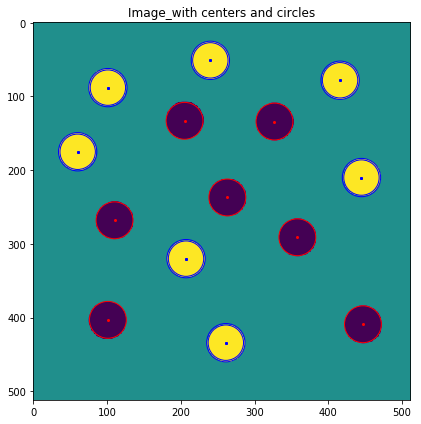

In [8]:
def scanScaleSpace(img, t_lst, s=3):
    r, c = img.shape
    L = np.zeros((len(t_lst),r,c))
    
    for i, t in enumerate(t_lst):
        scd_gauss = scd_deriv_gaussian(t, s) # Second dev. gaussian filter
        gauss = gaussian(t, s) # Gaussian filter
    
        L_xx = img
        L_xx = scipy.ndimage.convolve(L_xx, scd_gauss)
        L_xx = scipy.ndimage.convolve(L_xx, gauss.transpose())
    
        L_yy = img
        L_yy = scipy.ndimage.convolve(L_yy, scd_gauss.transpose())
        L_yy = scipy.ndimage.convolve(L_yy, gauss)
    
        L_nab = t*(L_xx + L_yy)
        
        L[i,:,:] = L_nab
        
    return L
min_size = 5
max_size = 40
sizes = np.arange(min_size, max_size)
t_lst = sizes**2/2

scale_space_L = scanScaleSpace(img, t_lst)
center_min = feature.peak_local_max(-scale_space_L, min_distance=1, threshold_rel=0.9)
center_max = feature.peak_local_max(scale_space_L, min_distance=1, threshold_rel=0.9)
    
center_min_2d = center_min[:,1:]
center_max_2d = center_max[:,1:]
# We plot the points from all detected scales:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(img, cmap='viridis')
ax.set_title('Image_with centers and circles')
ax.scatter(center_min_2d[:,1], center_min_2d[:,0], c='blue', s=4)
ax.scatter(center_max_2d[:,1], center_max_2d[:,0], c='red', s=4)
for iCirc in range(len(center_min_2d[:,1])):
    circ = plt.Circle((center_min_2d[iCirc,1], center_min_2d[iCirc,0]), sizes[center_min[iCirc,0]], edgecolor='blue', facecolor='None', fill=False)
    ax.add_artist(circ)
for iCirc in range(len(center_max_2d[:,1])):
    circ = plt.Circle((center_max_2d[iCirc,1], center_max_2d[iCirc,0]), sizes[center_max[iCirc,0]], edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
fig.show()
fig.tight_layout()
print("Detected scales: ", sizes[19], ", ", sizes[20], ", ", sizes[21])

## Real world example

In generic problems we do not know radius of blobs, so we must sweep across $t$ for different values and detect local maxima and minima to find the best scales. Look at scale space as 3-D space $(x, y, t)$. Find local maxima and minima across whole scale space comparing pixels with 26 neighbours. Must scale normalize to make scales comparable as we smoothen (and thus flatten) derivative values. Also min threshold on Laplacian value to remove noise.

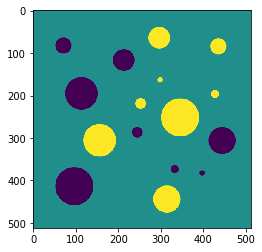

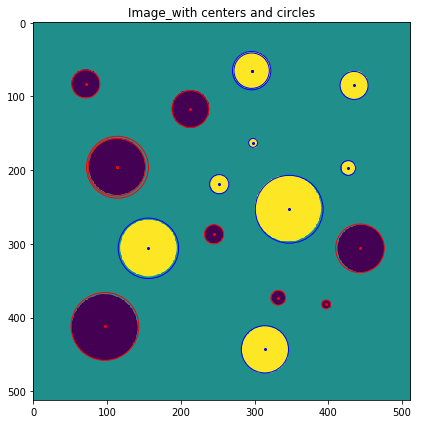

In [10]:
img = cv2.imread('EX_2_data/test_blob_varying.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)
plt.imshow(img)
plt.show()
min_size = 5
max_size = 50
sizes = np.arange(min_size, max_size)
t_lst = sizes**2/2

scale_space_L = scanScaleSpace(img, t_lst)

center_min = feature.peak_local_max(-scale_space_L, min_distance=1, threshold_rel=0.9)
center_max = feature.peak_local_max(scale_space_L, min_distance=1, threshold_rel=0.9)

center_min_2d = center_min[:,1:]
center_max_2d = center_max[:,1:]
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(img, cmap='viridis')
ax.set_title('Image_with centers and circles')
ax.scatter(center_min_2d[:,1], center_min_2d[:,0], c='blue', s=4)
ax.scatter(center_max_2d[:,1], center_max_2d[:,0], c='red', s=4)
for iCirc in range(len(center_min_2d[:,1])):
    circ = plt.Circle((center_min_2d[iCirc,1], center_min_2d[iCirc,0]), sizes[center_min[iCirc,0]], edgecolor='blue', facecolor='None', fill=False)
    ax.add_artist(circ)
for iCirc in range(len(center_max_2d[:,1])):
    circ = plt.Circle((center_max_2d[iCirc,1], center_max_2d[iCirc,0]), sizes[center_max[iCirc,0]], edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
fig.show()
fig.tight_layout()

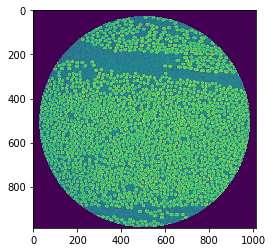

In [12]:
img = cv2.imread('EX_2_data/CT_lab_high_res.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)
plt.imshow(img)
plt.show()

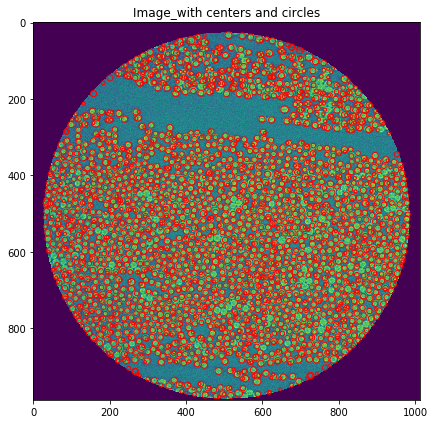

In [13]:
#min_size = 2
#max_size = 12

min_size = 3
max_size = 12
sizes = np.arange(min_size, max_size)
t_lst = sizes**2/2

scale_space_L = scanScaleSpace(img, t_lst)

#enter_min = feature.peak_local_max(-scale_space_L, min_distance=1, threshold_rel=0.25)
#center_max = feature.peak_local_max(scale_space_L, min_distance=1, threshold_rel=0.25)

center_min = feature.peak_local_max(-scale_space_L, min_distance=1, threshold_rel=0.3)
center_max = feature.peak_local_max(scale_space_L, min_distance=1, threshold_rel=0.3)

center_min_2d = center_min[:,1:]
center_max_2d = center_max[:,1:]
# We plot the points from all detected scales:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(img, cmap='viridis')
ax.set_title('Image_with centers and circles')
#ax.scatter(center_min_2d[:,1], center_min_2d[:,0], c='red', s=4)
#ax.scatter(center_max_2d[:,1], center_max_2d[:,0], c='red', s=4)
for iCirc in range(len(center_min_2d[:,1])):
    circ = plt.Circle((center_min_2d[iCirc,1], center_min_2d[iCirc,0]), sizes[center_min[iCirc,0]], edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
#for iCirc in range(len(center_max_2d[:,1])):
#    circ = plt.Circle((center_max_2d[iCirc,1], center_max_2d[iCirc,0]), sizes[center_max[iCirc,0]], edgecolor='red', facecolor='None', fill=False)
#    ax.add_artist(circ)
fig.show()
fig.tight_layout()